# Bank Data Analysis
## 
## Imports

In [6]:
import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## CSV To SQL Server

In [7]:
df = pd.read_csv("data/creditcard.csv", sep=",")

In [8]:
conn = pyodbc.connect("Driver={SQL Server};"
                      "Server=DESKTOP-L5ATCHA;"
                      "Database=CreditCard;"
                      "Trusted_Connection=yes;")

In [9]:
cursor = conn.cursor()

In [10]:
cursor.execute("truncate table StageTransactions")
cursor.execute("truncate table Transactions")

In [11]:
for row in df.itertuples():
    cursor.execute(
        '''
        insert into StageTransactions(
        [TimeOfDay],
        [V1], [V2], [V3], [V4], [V5],
        [V6], [V7], [V8], [V9], [V10],
        [V11], [V12], [V13], [V14], [V15],
        [V16], [V17], [V18], [V19], [V20],
        [V21], [V22], [V23], [V24], [V25],
        [V26], [V27], [V28],
        [Amount], [Class])
        values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
        ''',
        row.Time,
        row.V1, row.V2, row.V3, row.V4, row.V5,
        row.V6, row.V7, row.V8, row.V9, row.V10,
        row.V11, row.V12, row.V13, row.V14, row.V15,
        row.V16, row.V17, row.V18, row.V19, row.V20,
        row.V21, row.V22, row.V23, row.V24, row.V25,
        row.V26, row.V27, row.V28,
        row.Amount, row.Class
    )

In [12]:
conn.commit()

In [13]:
cursor.execute("exec ImportStage")

## Dataframe

In [14]:
df = pd.read_sql("select * from Transactions", conn)
df.drop("TransactionsID", axis=1, inplace=True)
#df["Time"] = df["Time"] % 86400
#df = df.loc[::10,:]
df

,Day,TimeOfDay,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1,51646,-0.052434,-0.231464,0.017448,-3.140754,0.545362,0.065513,0.347566,-0.443128,...,0.142327,0.955279,-0.355932,-0.097102,-0.128040,-0.067802,-0.254403,-0.072495,15.00,0
284803,1,51647,-0.662567,1.523028,0.647569,2.416724,1.148016,-0.450908,1.679818,-0.196755,...,0.331603,0.851241,-0.423252,0.022144,0.428041,0.175707,-0.072209,0.111014,37.93,0
284804,1,51647,1.910699,0.173019,-2.034973,0.886090,0.334556,-1.341704,0.404374,-0.348540,...,-0.128169,-0.157775,0.024594,-0.166918,0.161940,-0.297787,0.012252,0.000327,59.44,0
284805,1,51647,2.017727,0.017121,-3.413577,0.129556,3.141497,2.988440,0.274226,0.545435,...,0.185227,0.486681,-0.045034,0.713508,0.591599,-0.397269,-0.023108,-0.069086,29.00,0


In [15]:
df.isnull().sum()

Day          0
TimeOfDay    0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
V8           0
V9           0
V10          0
V11          0
V12          0
V13          0
V14          0
V15          0
V16          0
V17          0
V18          0
V19          0
V20          0
V21          0
V22          0
V23          0
V24          0
V25          0
V26          0
V27          0
V28          0
Amount       0
Class        0
dtype: int64

## Ploting Data

<AxesSubplot:xlabel='Class', ylabel='count'>

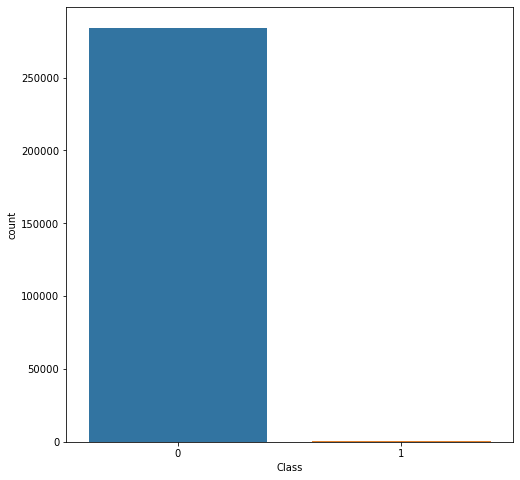

In [11]:
plt.rcParams["figure.figsize"] = (8,8)
sns.countplot(data=df, x="Class")

<BarContainer object of 492 artists>

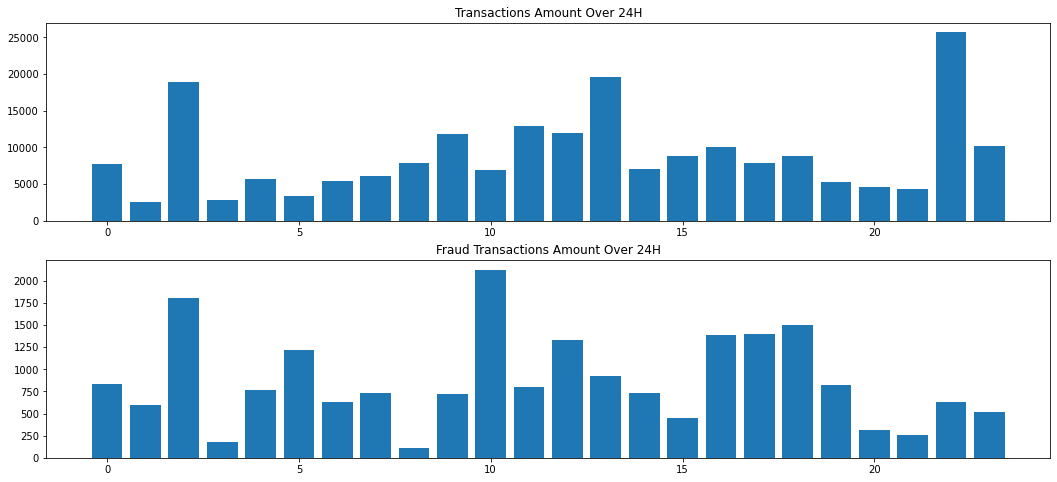

In [12]:
plt.rcParams["figure.figsize"] = (18,8)
fig, axes = plt.subplots(2)
axes[0].set_title("Transactions Amount Over 24H")
axes[0].bar((df[df["Class"] == 0])["TimeOfDay"]//3600, (df[df["Class"] == 0])["Amount"])
axes[1].set_title("Fraud Transactions Amount Over 24H")
axes[1].bar((df[df["Class"] == 1])["TimeOfDay"]//3600, (df[df["Class"] == 1])["Amount"])

<AxesSubplot:>

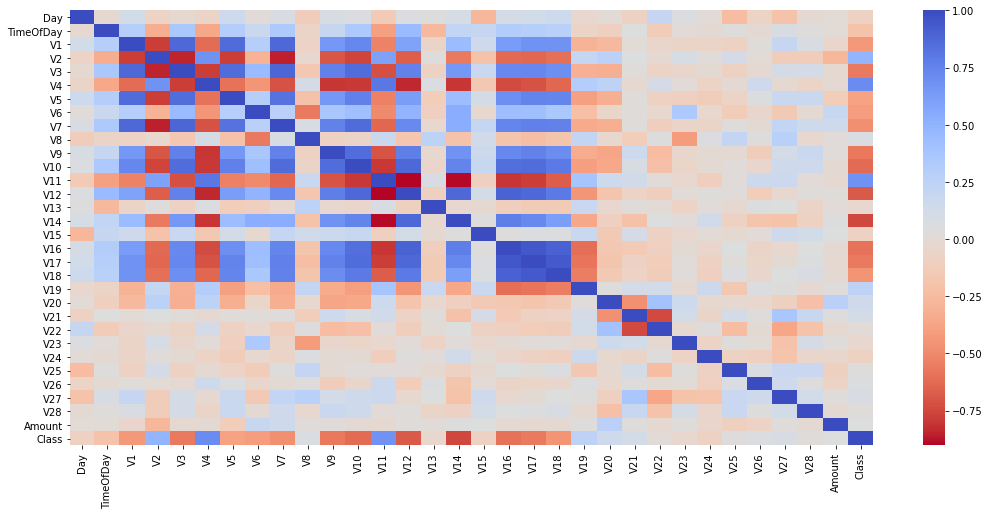

In [13]:
df_corr = (df[df["Class"] == 0].sample(frac=1)).head(df["Class"].sum())
df_corr = pd.concat([df_corr, df[df["Class"] == 1]])
sns.heatmap(df_corr.corr(), cmap='coolwarm_r')

### Results:
- Non 'nan' values
- Imbalanced classes
- Most fraud transactions take place when there are little transactions overall
- Positive Correlation: V2 V4 V11
- Negative Correlation: V10 V12 V14

## Features

In [16]:
col_id = 0
for col in df.columns:
    print(col_id,"\t", col)
    col_id+=1
print("Total size:", df.shape)

0 	 Day
1 	 TimeOfDay
2 	 V1
3 	 V2
4 	 V3
5 	 V4
6 	 V5
7 	 V6
8 	 V7
9 	 V8
10 	 V9
11 	 V10
12 	 V11
13 	 V12
14 	 V13
15 	 V14
16 	 V15
17 	 V16
18 	 V17
19 	 V18
20 	 V19
21 	 V20
22 	 V21
23 	 V22
24 	 V23
25 	 V24
26 	 V25
27 	 V26
28 	 V27
29 	 V28
30 	 Amount
31 	 Class
Total size: (284807, 32)


## To numpy

In [17]:
X = df.loc[:, df.columns != "Class"].to_numpy()
y = df["Class"].to_numpy()
print("X:", X.shape, "\ny:", y.shape)

X: (284807, 31) 
y: (284807,)


## Normalizing

In [18]:
X = normalize(X, axis=0, norm="max")

for i in range(X.shape[1]):
    print(X[:,i].min(), " - ", X[:,i].max())

0.0  -  1.0
0.0  -  1.0
-1.0  -  0.04352133266042524
-1.0  -  0.3033419279398876
-1.0  -  0.19415300582184283
-0.33677364958339207  -  1.0
-1.0  -  0.3059667147276482
-0.35688848290873254  -  1.0
-0.36120262343107  -  1.0
-1.0  -  0.27326010762616926
-0.8614344959176816  -  1.0
-1.0  -  0.9657102115798231
-0.3991603394002527  -  1.0
-1.0  -  0.42006593601241343
-0.8126808367656516  -  1.0
-1.0  -  0.5478602960650424
-0.5067667973023792  -  1.0
-0.8160417854143233  -  1.0
-1.0  -  0.36774629542027587
-1.0  -  0.5307089196103384
-1.0  -  0.775206233214242
-1.0  -  0.7233495986708394
-1.0  -  0.7810089204365862
-1.0  -  0.9606651463108603
-1.0  -  0.5027795220470931
-0.6187362887820688  -  1.0
-1.0  -  0.730383551400813
-0.7404875267874987  -  1.0
-0.7138282268452074  -  1.0
-0.45586656566061945  -  1.0
0.0  -  1.0


## Test/Train. Class Balance
Define a function to print importand information about given data

In [19]:
def balance_size_fraud(heading, labels):
    print("_" + heading)
    print("Balance:", 100 - labels.sum() * 100 / labels.shape[0])
    print("Size:", labels.shape[0])
    print("Fraud:", labels.sum(), "\n")

In [20]:
balance_size_fraud("df", y)

_df
Balance: 99.827251436938
Size: 284807
Fraud: 492 



Spliting the data

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

balance_size_fraud("train", y_train)
balance_size_fraud("test", y_test)

_train
Balance: 99.82444205490575
Size: 227845
Fraud: 400 

_test
Balance: 99.83848881710614
Size: 56962
Fraud: 92 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

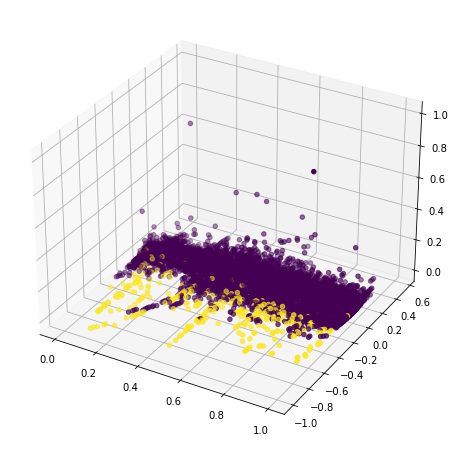

In [49]:
plt.axes(projection='3d').scatter3D(X_train[:,1],
                                    X_train[:,15],
                                    X_train[:,30],
                                    c=y_train)
plt

## Samples

### Undersample

In [50]:
b_coef = 2

In [51]:
#X_train_random = (X_train[y_train_class0_mask, :])[:y_train.sum(), :]
#y_train_random = np.zeros((X_train_random.shape[0],))
#X_train_random = np.append(X_train_random, X_train[y_train_class1_mask], axis=0)
#y_train_random = np.append(y_train_random, np.ones((y_train.sum(),)), axis=0)

undersampler = NearMiss(sampling_strategy=0.0017*b_coef)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

print("X_train_undersampled.shape: ", X_train_undersampled.shape)
print("y_train_undersampled.shape: ", y_train_undersampled.shape)

balance_size_fraud("train_undersample", y_train_undersampled)

X_train_undersampled.shape:  (118047, 31)
y_train_undersampled.shape:  (118047,)
_train_undersample
Balance: 99.66115191406813
Size: 118047
Fraud: 400 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

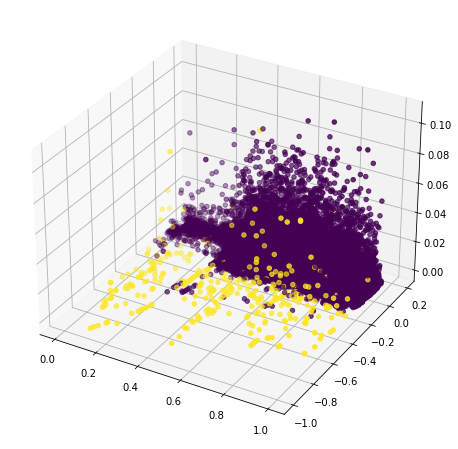

In [52]:
plt.axes(projection='3d').scatter3D(X_train_undersampled[:,1],
                                    X_train_undersampled[:,15],
                                    X_train_undersampled[:,30],
                                    c=y_train_undersampled)
plt

### Oversample

In [53]:
oversampler = SMOTE(sampling_strategy=0.0017*b_coef)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

print("X_train_oversampled.shape: ", X_train_oversampled.shape)
print("y_train_oversampled.shape: ", y_train_oversampled.shape)

balance_size_fraud("train_oversampled", y_train_oversampled)

X_train_oversampled.shape:  (228218, 31)
y_train_oversampled.shape:  (228218,)
_train_oversampled
Balance: 99.66128876775714
Size: 228218
Fraud: 773 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

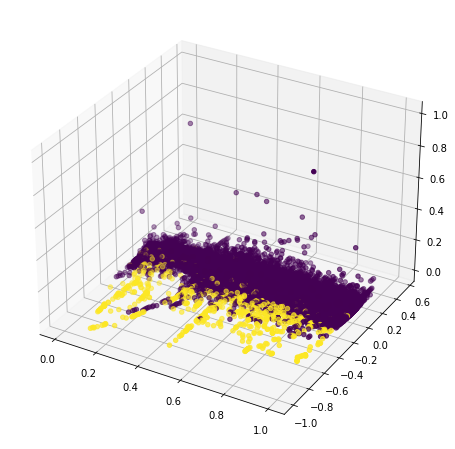

In [54]:
plt.axes(projection='3d').scatter3D(X_train_oversampled[:,1],
                                    X_train_oversampled[:,15],
                                    X_train_oversampled[:,30],
                                    c=y_train_oversampled)
plt

### Combined method

In [55]:
comb = NearMiss(sampling_strategy=0.0017*math.sqrt(b_coef))
X_train_combined, y_train_combined = comb.fit_resample(X_train, y_train)
comb = SMOTE(sampling_strategy=0.0017*b_coef)
X_train_combined, y_train_combined = comb.fit_resample(X_train_combined, y_train_combined)

print("X_train_combined.shape: ", X_train_combined.shape)
print("y_train_combined.shape: ", y_train_combined.shape)

balance_size_fraud("train_combined", y_train_combined)

X_train_combined.shape:  (166943, 31)
y_train_combined.shape:  (166943,)
_train_combined
Balance: 99.66156113164374
Size: 166943
Fraud: 565 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

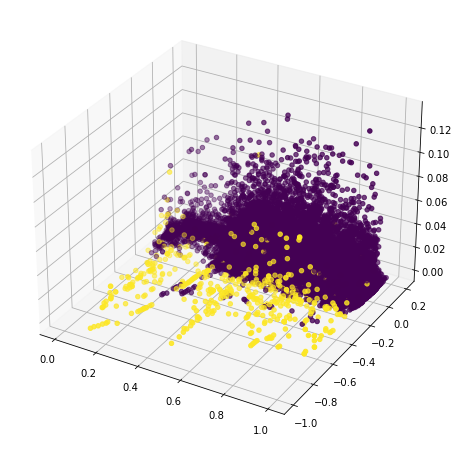

In [56]:
plt.axes(projection='3d').scatter3D(X_train_combined[:,1],
                                    X_train_combined[:,15],
                                    X_train_combined[:,30],
                                    c=y_train_combined)
plt

## Using Different Splits of Data To Compare Models

In [30]:
def get_neural_model():
    return keras.Sequential([
        layers.Input(shape=(31)),
        layers.Dense(31, activation="relu"),
        layers.Dense(31, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

In [45]:
def compile_model(model, X_train, y_train, weights):
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(lr=0.001)
    )
    if weights == "balanced":
        weights = None
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0, class_weight=weights)

In [32]:
def get_classifiers(X_train, y_train, balanced=None):
    classifiers = {}

    # Logistic Regression
    log_reg_params = {
        "penalty": ["none"], # "l1", "l2"
        "max_iter": [5000], # 100, 500, 1000, 5000, 10000
        "solver": ["lbfgs"],
        "class_weight": [balanced]
    }
    
    grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
    grid_log_reg.fit(X_train, y_train)
    # Save best
    classifiers["LogisiticRegression"] = grid_log_reg.best_estimator_
    #print("LogisiticRegression", grid_log_reg.best_params_)
    
    # Decision Tree
    tree_params = {
        "criterion": ["gini"], # "entrophy"
        "max_depth": [14],  # 2, 4, 6, 8, 10, 12, 14, 16
        "min_samples_leaf": [5], # 3, 5, 8, ..., 40
        "class_weight": [balanced]
    }
    
    grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
    grid_tree.fit(X_train, y_train)
    # Save best
    classifiers["DecisionTreeClassifier"] = grid_tree.best_estimator_
    #print("DecisionTreeClassifier", grid_tree.best_params_)
    
    #Neural Network
    classifiers["NeuralNetwork"] = get_neural_model()
    compile_model(classifiers["NeuralNetwork"], X_train, y_train, balanced)
    
    return classifiers

In [33]:
def get_model_score(X_train, X_test, y_train, y_test, classifiers):
    scores = {}
    print("\t\t\tPRECISION\tRECALL\t\tF1")
    for name, classifier in classifiers.items():
        #test score
        predicted = [int(i > 0.5) for i in classifier.predict(X_train)]
        train_precision = round(precision_score(y_train, predicted) * 100, 3)
        train_recall = round(recall_score(y_train, predicted) * 100, 3)
        train_f1 = round(f1_score(y_train, predicted) * 100, 3)
        
        #train score
        predicted = [int(i > 0.5) for i in classifier.predict(X_test)]
        test_precision = round(precision_score(y_test, predicted) * 100, 3)
        test_recall = round(recall_score(y_test, predicted) * 100, 3)
        test_f1 = round(f1_score(y_test, predicted) * 100, 3)
        
        print(name +"\n\t\tTRAIN\t"
              + str(train_precision) + "\t\t" + str(train_recall) + "\t\t" + str(train_f1) + "\n\t\tTEST\t"
              + str(test_precision) + "\t\t" + str(test_recall) + "\t\t" + str(test_f1))
        
        scores[name] = [train_precision, train_recall, train_f1, test_precision, test_recall, test_f1]
    return scores

In [34]:
print("\n ORIGINAL \n")
models = get_classifiers(X_train, y_train)
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 ORIGINAL 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	88.256		62.0		72.834
		TEST	88.71		59.783		71.429
DecisionTreeClassifier
		TRAIN	96.165		81.5		88.227
		TEST	85.366		76.087		80.46
NeuralNetwork
		TRAIN	93.605		80.5		86.559
		TEST	94.872		80.435		87.059


{'LogisiticRegression': [88.256, 62.0, 72.834, 88.71, 59.783, 71.429],
 'DecisionTreeClassifier': [96.165, 81.5, 88.227, 85.366, 76.087, 80.46],
 'NeuralNetwork': [93.605, 80.5, 86.559, 94.872, 80.435, 87.059]}

In [33]:
print("\n UNDERSAMPLED \n")
models = get_classifiers(X_train_undersampled, y_train_undersampled)
get_model_score(X_train_undersampled, X_test,
                y_train_undersampled, y_test,
                models)


 UNDERSAMPLED 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	90.504		75.309		82.21
		TEST	29.947		64.368		40.876
DecisionTreeClassifier
		TRAIN	98.246		82.963		89.96
		TEST	55.085		74.713		63.415
NeuralNetwork
		TRAIN	93.132		83.704		88.166
		TEST	39.157		74.713		51.383


{'LogisiticRegression': [90.504, 75.309, 82.21, 29.947, 64.368, 40.876],
 'DecisionTreeClassifier': [98.246, 82.963, 89.96, 55.085, 74.713, 63.415],
 'NeuralNetwork': [93.132, 83.704, 88.166, 39.157, 74.713, 51.383]}

In [34]:
print("\n OVERSAMPLED \n")
models = get_classifiers(X_train_oversampled, y_train_oversampled)
get_model_score(X_train_oversampled, X_test,
                y_train_oversampled, y_test,
                models)


 OVERSAMPLED 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	92.492		74.903		82.773
		TEST	80.882		63.218		70.968
DecisionTreeClassifier
		TRAIN	97.778		85.382		91.16
		TEST	86.842		75.862		80.982
NeuralNetwork
		TRAIN	89.286		87.322		88.293
		TEST	81.395		80.46		80.925


{'LogisiticRegression': [92.492, 74.903, 82.773, 80.882, 63.218, 70.968],
 'DecisionTreeClassifier': [97.778, 85.382, 91.16, 86.842, 75.862, 80.982],
 'NeuralNetwork': [89.286, 87.322, 88.293, 81.395, 80.46, 80.925]}

In [35]:
print("\n COMBINED \n")
models = get_classifiers(X_train_combined, y_train_combined)
get_model_score(X_train_combined, X_test,
                y_train_combined, y_test,
                models)


 COMBINED 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	92.827		76.923		84.13
		TEST	49.138		65.517		56.158
DecisionTreeClassifier
		TRAIN	98.0		85.664		91.418
		TEST	63.636		72.414		67.742
NeuralNetwork
		TRAIN	93.256		84.615		88.726
		TEST	70.968		75.862		73.333


{'LogisiticRegression': [92.827, 76.923, 84.13, 49.138, 65.517, 56.158],
 'DecisionTreeClassifier': [98.0, 85.664, 91.418, 63.636, 72.414, 67.742],
 'NeuralNetwork': [93.256, 84.615, 88.726, 70.968, 75.862, 73.333]}

In [35]:
print("\n BALANCED - 0.5 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 0.5})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 0.5 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	87.013		50.25		63.708
		TEST	86.538		48.913		62.5
DecisionTreeClassifier
		TRAIN	97.248		79.5		87.483
		TEST	87.179		73.913		80.0
NeuralNetwork
		TRAIN	96.716		81.0		88.163
		TEST	96.154		81.522		88.235


{'LogisiticRegression': [87.013, 50.25, 63.708, 86.538, 48.913, 62.5],
 'DecisionTreeClassifier': [97.248, 79.5, 87.483, 87.179, 73.913, 80.0],
 'NeuralNetwork': [96.716, 81.0, 88.163, 96.154, 81.522, 88.235]}

In [36]:
print("\n BALANCED - 0.75 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 0.75})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 0.75 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	88.077		57.25		69.394
		TEST	87.931		55.435		68.0
DecisionTreeClassifier
		TRAIN	94.872		83.25		88.682
		TEST	86.905		79.348		82.955
NeuralNetwork
		TRAIN	97.853		79.75		87.879
		TEST	96.053		79.348		86.905


{'LogisiticRegression': [88.077, 57.25, 69.394, 87.931, 55.435, 68.0],
 'DecisionTreeClassifier': [94.872, 83.25, 88.682, 86.905, 79.348, 82.955],
 'NeuralNetwork': [97.853, 79.75, 87.879, 96.053, 79.348, 86.905]}

In [37]:
print("\n BALANCED - 2 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 2})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 2 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	84.77		73.75		78.877
		TEST	84.0		68.478		75.449
DecisionTreeClassifier
		TRAIN	90.39		87.0		88.662
		TEST	77.895		80.435		79.144
NeuralNetwork
		TRAIN	93.696		81.75		87.316
		TEST	92.857		84.783		88.636


{'LogisiticRegression': [84.77, 73.75, 78.877, 84.0, 68.478, 75.449],
 'DecisionTreeClassifier': [90.39, 87.0, 88.662, 77.895, 80.435, 79.144],
 'NeuralNetwork': [93.696, 81.75, 87.316, 92.857, 84.783, 88.636]}

In [38]:
print("\n BALANCED - 5 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 5})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 5 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	79.798		79.0		79.397
		TEST	76.842		79.348		78.075
DecisionTreeClassifier
		TRAIN	74.455		94.0		83.094
		TEST	60.156		83.696		70.0
NeuralNetwork
		TRAIN	85.714		84.0		84.848
		TEST	83.158		85.87		84.492


{'LogisiticRegression': [79.798, 79.0, 79.397, 76.842, 79.348, 78.075],
 'DecisionTreeClassifier': [74.455, 94.0, 83.094, 60.156, 83.696, 70.0],
 'NeuralNetwork': [85.714, 84.0, 84.848, 83.158, 85.87, 84.492]}

In [39]:
print("\n BALANCED - 10 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 10})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 10 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	77.831		80.75		79.264
		TEST	76.471		84.783		80.412
DecisionTreeClassifier
		TRAIN	69.384		95.75		80.462
		TEST	54.93		84.783		66.667
NeuralNetwork
		TRAIN	79.812		85.0		82.324
		TEST	76.923		86.957		81.633


{'LogisiticRegression': [77.831, 80.75, 79.264, 76.471, 84.783, 80.412],
 'DecisionTreeClassifier': [69.384, 95.75, 80.462, 54.93, 84.783, 66.667],
 'NeuralNetwork': [79.812, 85.0, 82.324, 76.923, 86.957, 81.633]}

In [40]:
print("\n BALANCED - 20 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 20})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 20 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	68.107		82.75		74.718
		TEST	62.308		88.043		72.973
DecisionTreeClassifier
		TRAIN	70.073		96.0		81.013
		TEST	55.396		83.696		66.667
NeuralNetwork
		TRAIN	58.347		88.25		70.249
		TEST	56.849		90.217		69.748


{'LogisiticRegression': [68.107, 82.75, 74.718, 62.308, 88.043, 72.973],
 'DecisionTreeClassifier': [70.073, 96.0, 81.013, 55.396, 83.696, 66.667],
 'NeuralNetwork': [58.347, 88.25, 70.249, 56.849, 90.217, 69.748]}

In [41]:
print("\n BALANCED - 50 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 50})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 50 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	44.314		84.75		58.197
		TEST	40.291		90.217		55.705
DecisionTreeClassifier
		TRAIN	69.286		97.0		80.833
		TEST	50.98		84.783		63.673
NeuralNetwork
		TRAIN	43.325		89.25		58.333
		TEST	41.262		92.391		57.047


{'LogisiticRegression': [44.314, 84.75, 58.197, 40.291, 90.217, 55.705],
 'DecisionTreeClassifier': [69.286, 97.0, 80.833, 50.98, 84.783, 63.673],
 'NeuralNetwork': [43.325, 89.25, 58.333, 41.262, 92.391, 57.047]}

In [42]:
print("\n BALANCED - 100 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 100})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 100 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	23.992		86.25		37.541
		TEST	22.703		91.304		36.364
DecisionTreeClassifier
		TRAIN	68.0		97.75		80.205
		TEST	54.483		85.87		66.667
NeuralNetwork
		TRAIN	27.894		89.75		42.561
		TEST	27.419		92.391		42.289


{'LogisiticRegression': [23.992, 86.25, 37.541, 22.703, 91.304, 36.364],
 'DecisionTreeClassifier': [68.0, 97.75, 80.205, 54.483, 85.87, 66.667],
 'NeuralNetwork': [27.894, 89.75, 42.561, 27.419, 92.391, 42.289]}

In [46]:
print("\n BALANCED - DEF \n")
models = get_classifiers(X_train, y_train, "balanced")
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - DEF 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	6.155		92.5		11.543
		TEST	5.692		93.478		10.73
DecisionTreeClassifier
		TRAIN	45.147		100.0		62.208
		TEST	34.667		84.783		49.211
NeuralNetwork
		TRAIN	96.308		78.25		86.345
		TEST	96.0		78.261		86.228


{'LogisiticRegression': [6.155, 92.5, 11.543, 5.692, 93.478, 10.73],
 'DecisionTreeClassifier': [45.147, 100.0, 62.208, 34.667, 84.783, 49.211],
 'NeuralNetwork': [96.308, 78.25, 86.345, 96.0, 78.261, 86.228]}